# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [3]:
theoretical_values = [50, 0.69]

In [4]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=theoretical_values[1])
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [5]:
srate = 4096
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = 1e-22*np.exp(-1j*omega*t_range_prepad/(theoretical_values[0]*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 1e-23*np.random.normal(size = srate)

(0.245, 0.265)

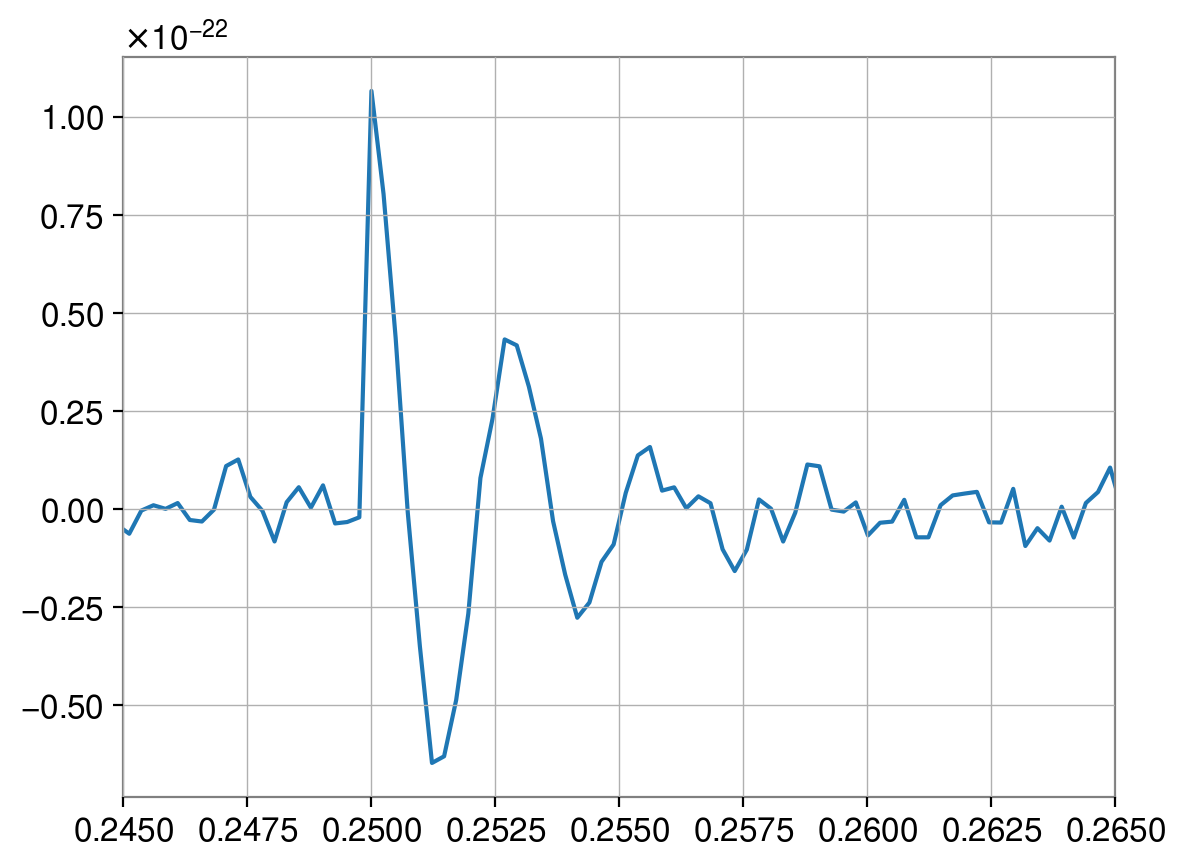

In [6]:
data = signal + .5*noise
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [7]:
mass = qnm_filter.Filter.mass_unit(50)

In [8]:
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25+3*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [9]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')
fit.cholesky_decomposition()
fit.first_index()

In [10]:
fit_temp = qnm_filter.Network(**input)
fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
fit_temp.detector_alignment()
fit_temp.condition_data('original_data', **input, trim = 0.0)
fit_temp.compute_acfs('original_data')
fit_temp.cholesky_decomposition()
fit_temp.first_index()
data = fit.truncate_data(fit.original_data)['H1']
template = fit_temp.truncate_data(fit_temp.original_data)['H1']

<AxesSubplot: >

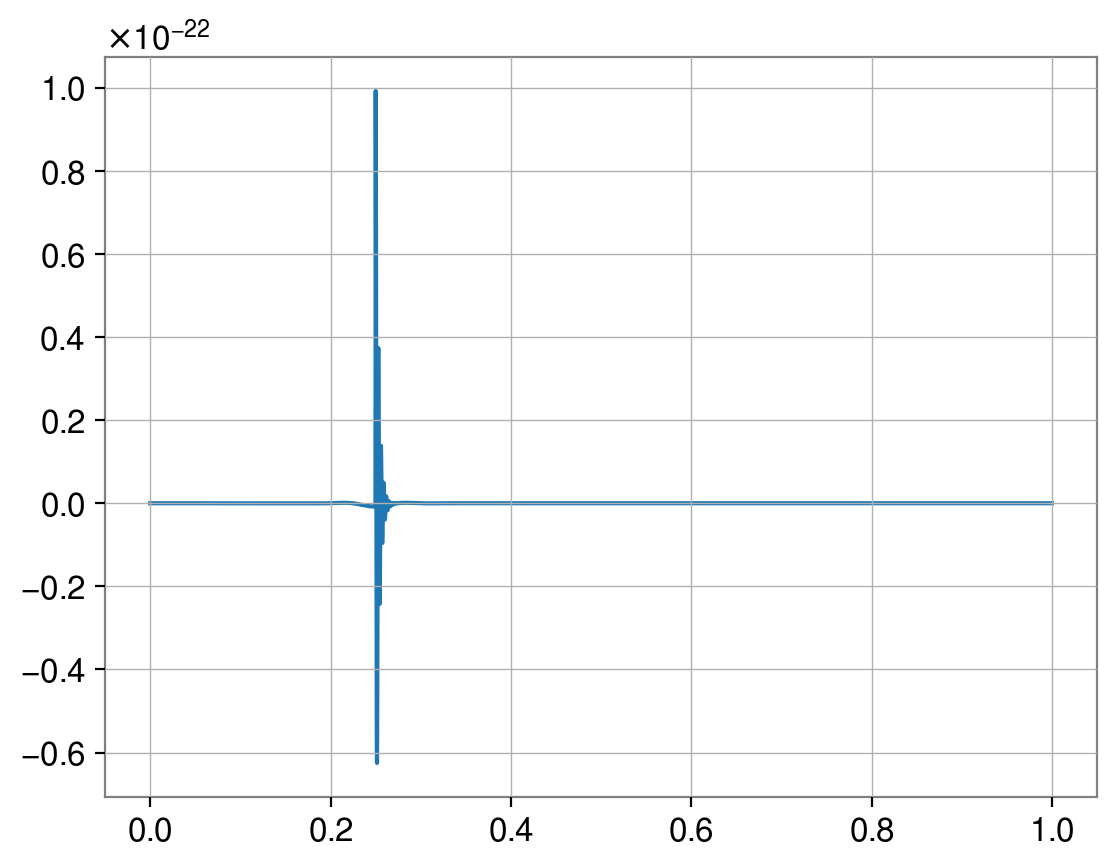

In [11]:
fit_temp.original_data['H1'].plot()

In [12]:
fit.compute_SNR(data, template, 'H1', optimal=True)

21.326148076441648

In [26]:
snr_points = 30
realisation_number = 30
scaling_arr = np.logspace(-1, 0.3, snr_points)
realisation_SNR = []
realisation_bayes = []

for i in range(realisation_number):
    noise = 1e-23*np.random.normal(size = srate)
    SNR_arr = []
    bayes_arr = []
    for j in scaling_arr:
        data = signal + j*noise

        fit = qnm_filter.Network(**input)
        fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
        fit.detector_alignment()
        fit.condition_data('original_data', **input, trim = 0.0)
        fit.pure_noise = {}
        fit.pure_noise['H1'] = qnm_filter.RealData(j*noise, 
                                           index = t_range)
        fit.compute_acfs('pure_noise')
        fit.cholesky_decomposition()
        fit.first_index()

        fit_temp = qnm_filter.Network(**input)
        fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
        fit_temp.detector_alignment()
        fit_temp.condition_data('original_data', **input, trim = 0.0)
        fit_temp.first_index()
        data = fit.truncate_data(fit.original_data)['H1']
        template = fit_temp.truncate_data(fit_temp.original_data)['H1']

        SNR = fit.compute_SNR(data, template, 'H1', optimal=False)
        fit.compute_likelihood(apply_filter = False)
        fit.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
        Bayes = fit.compute_likelihood() - fit.compute_likelihood(apply_filter=False)

        bayes_arr.append(Bayes)
        SNR_arr.append(SNR)
    realisation_SNR.append(SNR_arr)
    realisation_bayes.append(bayes_arr)

In [28]:
med_snr = np.array([np.median([realisation_snr[i,j] for i in range(realisation_number)]) for j in range(snr_points)])
med_bayes = np.array([np.median([realisation_bayes[i,j] for i in range(realisation_number)]) for j in range(snr_points)])
std_bayes = np.array([np.std([realisation_bayes[i,j] for i in range(realisation_number)]) for j in range(snr_points)])

Text(0, 0.5, 'log$^2_{10}$(Bayes factor))')

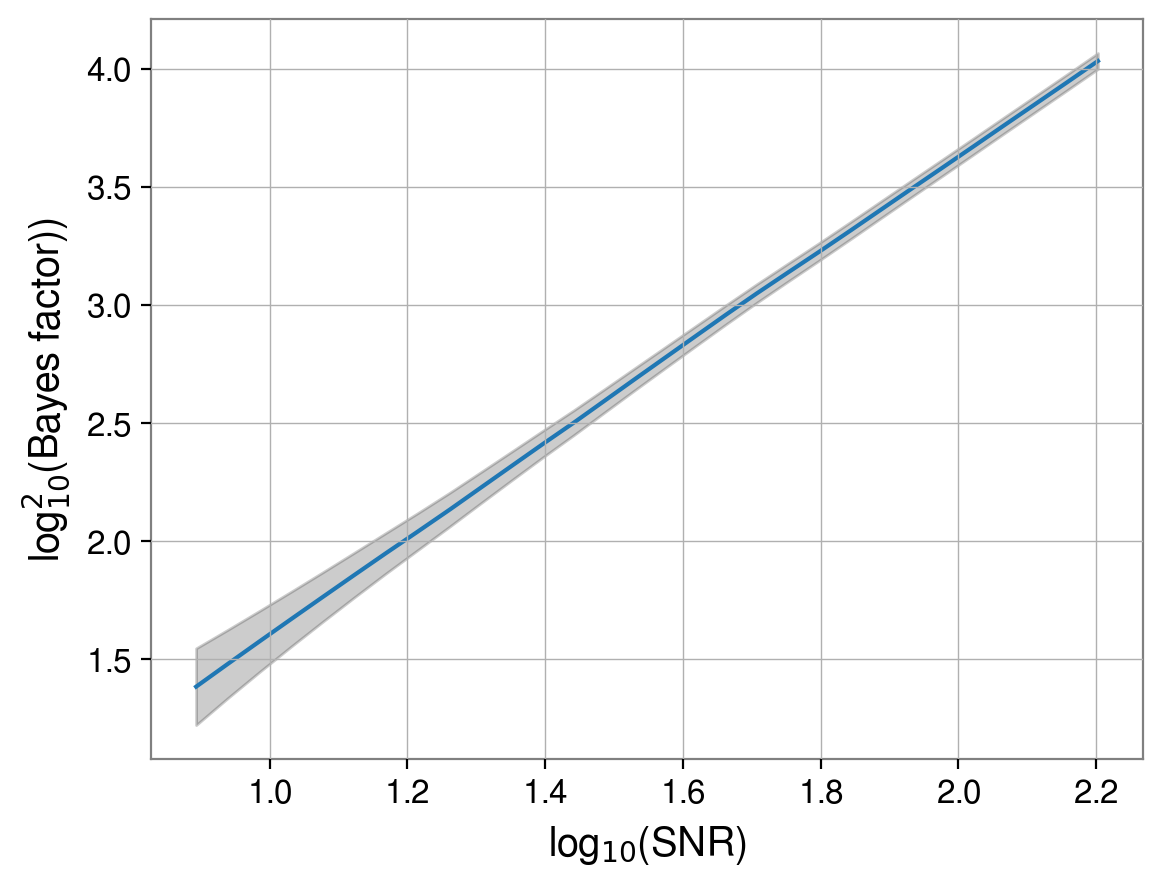

In [29]:
pl.plot(med_snr, med_bayes)
pl.fill_between(med_snr, 
                med_bayes-std_bayes, med_bayes+std_bayes,
               alpha = 0.2, color = 'k')
pl.xlabel("log$_{10}$(SNR)")
pl.ylabel("log$^2_{10}$(Bayes factor))")
# pl.text(1.25, 1.25, 'Slope = 1.999 $\pm$ 0.003')

In [30]:
np.polyfit(med_snr, med_bayes, deg=1, cov = True)

(array([ 2.0233977 , -0.41595994]),
 array([[ 6.04934261e-06, -9.38249470e-06],
        [-9.38249470e-06,  1.54708433e-05]]))

In [19]:
realisations = np.array([np.polyfit(realisation_snr[i], realisation_bayes[i],
                                deg=1, cov=False) for i in range(realisation_number)])
slopes = realisations[:,0]
intercepts = realisations[:,1]

In [20]:
print(np.median(slopes), np.std(slopes))

2.004336805522816 0.02868522013637222


In [48]:
print(np.median(intercepts), np.std(intercepts))

-0.3298779826630651 0.12938237009129452


In [18]:
# Truncate into sections
# Increase statistics

In [49]:
np.log10(0.5)

-0.3010299956639812